In [1]:
import os
import sys
# print(sys.path)
import subprocess
import shutil
import pandas as pd
import numpy as np
import calendar
import traceback
import json
from pyutils import *
from pdutils import *
from pdpltutils import *
from gputils import *
from iputils import *
import xmltodict
import re

In [3]:
if sys.platform == "linux":
    DATADIR="/home/jblake1/Downloads/Network_Measurements"
else:
    DATADIR="P:\\My Drive\\CMU-LEL\\Mill19\\Images\\Coverage and Performance"
    EXPDIR=os.path.join(*[DATADIR,"2024-09-10-Mill19-Testing","LEL-UE1"])

DIRCHECKLIST=[DATADIR,EXPDIR]
for DIR in DIRCHECKLIST:
    print(f"{DIR} exists") if os.path.isdir(DIR) else print(f"{DIR} does not exist")

P:\My Drive\CMU-LEL\Mill19\Images\Coverage and Performance exists
P:\My Drive\CMU-LEL\Mill19\Images\Coverage and Performance\2024-09-10-Mill19-Testing\LEL-UE1 exists


In [4]:
pngfiles = [os.path.join(EXPDIR,fn) for fn in os.listdir(EXPDIR) if fn.endswith(".png")]

In [5]:
tdfx = pd.DataFrame(pngfiles,columns=["PNGFFN"])

In [6]:
tdfx['TXTFFN'] = tdfx.PNGFFN.str.replace(".png",".txt")
tdfx['TXTEXISTS'] = tdfx.TXTFFN.map(lambda xx: os.path.exists(xx))
tdfx['CSVFFN'] = tdfx.PNGFFN.str.replace(".png",".csv")
tdfx['CSVEXISTS'] = tdfx.CSVFFN.map(lambda xx: os.path.exists(xx))
tdfx['PNGDATE'] = tdfx.PNGFFN.map(lambda xx: os.path.basename(xx).replace("Screenshot_","").replace(".png",""))
tdfx = tdfx.sort_values(["PNGFFN"]).reset_index(drop=True)
dumpdf(tdfx)

(68, 6)
                                              PNGFFN  \
0  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...   
1  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...   
2  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...   
3  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...   
4  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...   

                                              TXTFFN  TXTEXISTS  \
0  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...       True   
1  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...       True   
2  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...       True   
3  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...       True   
4  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...       True   

                                              CSVFFN  CSVEXISTS  \
0  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...      False   
1  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and...      False   
2  P:\My Drive\CMU-LEL\Mill19\Images\Coverage and..

In [ ]:
print(tdfx.TXTFFN.iloc[0])

In [ ]:
def classifyFile(row):
    fn = row['TXTFFN']
    # print(fn)
    lines = []
    datalst = []
    fclass = "UNKNOWN"
    with open(fn,'r') as f:
        lines = f.readlines()
    lines = [line.rstrip('\n') for line in lines if line != "\n" and line != " "]
    pingfile, kwline = kwInFile(lines,"PING")
    if pingfile:
        fclass = "PING"
        pdest = kwline.split(" ")[0]
        haspstats, pstats = kwInFile(lines,"Ping statistics:",offset=1)
        haststats, tstats = kwInFile(lines,"Time statistics:",offset=1)
        # print(f"pdest={pdest},hasstats={haspstats}, pstats={pstats}, tstats={tstats},kwline={kwline}\n\n{lines}")
        datalst = [pdest,haspstats, pstats, haststats, tstats]
    iperfile, kwline = kwInFile(lines,"bit/sec")
    if iperfile:
        fclass = "IPERF"
        hasidest, kwline = kwInFile(lines," START")
        idest = kwline.split(" ")[0]
        hasircv, ircv = kwInFile(lines,"Receiver summary",offset=1)
        hasisnd, isnd = kwInFile(lines,"Sender summary",offset=1)
        # print(f"idest={idest},hasircv={hasircv}, ircv={ircv}, isnd={isnd}")
        datalst = [idest,hasircv,ircv,hasisnd,isnd]
        # print(datalst)
    cellfile, kwline = kwInFile(lines,"Longitude:")
    if cellfile:
        fclass = "CELL"
        geoloc = kwline
        hascperf, cperf = kwInFile(lines,"SNR:")
        datalst = [geoloc, hascperf, cperf]

    mapfile, kwline = kwInFile(lines,"314-737")
    if mapfile:
        fclass = "MAP"
        hasmperf, mperf = kwInFile(lines,"SNR:")
        hasminfo, minfo = kwInFile(lines,"PCI:")
        datalst = [hasmperf, mperf, hasminfo,minfo]

    speedfile, kwline = kwInFile(lines,"Internet speed test")
    if speedfile:
        fclass = "SPEED"
        hasspeed, speed = kwInFile(lines,"Internet speed test",offset=1)
        datalst = [hasspeed, speed]
    
    return fclass,datalst

def kwInFile(lines,kw,offset=0):
    retval = False
    for ii,line in enumerate(lines):
        if kw in line:
            retval = True
            break
    return retval,lines[ii+offset]
    

tdfx[['FCLASS','DATALST']] = tdfx.apply(classifyFile,axis=1,result_type="expand")
dumpdf(tdfx,head = 20)
# tdfx[:6].apply(classifyFile,axis=1)


In [ ]:
tdfx['DATAFIELD1'] = tdfx.DATALST.map(len).max()

In [ ]:
tdfx[['DATAFIELD1','DATAFIELD2','DATAFIELD3','DATAFIELD4','DATAFIELD5']] = pd.DataFrame(tdfx.DATALST.tolist(),index = tdfx.index)

In [ ]:
dumpdf(tdfx)

In [ ]:
tdfx = drp_lst(tdfx,["DATALST"])
dumpdf(tdfx)

In [ ]:
writejoin(tdfx,".","tmp.csv")

In [ ]:
del tdfx

In [ ]:
tdfy = drp_lst(readjoin(".","tmp-edited.csv"),['Unnamed: 0'])
dumpdf(tdfy)

In [ ]:
# Ping Stats
bdf = (tdfy.FCLASS == "PING") & (tdfy.DATAFIELD2)
tdfy['PINGSTATS'] = tdfy[bdf].DATAFIELD3.map(lambda xx: [xx.split(" ")[0], float(xx.split(" ")[4].strip("%"))])
dumpdf(tdfy[bdf].PINGSTATS,head=len(tdfy))

In [ ]:
# Ping Times
bdf = (tdfy.FCLASS == "PING") & (tdfy.DATAFIELD4)
tdfy['PINGTIMES'] = tdfy[bdf].DATAFIELD5.map(lambda xx: re.sub("\s\s+" , " ", xx.replace("\\","")).split(" ")[1::2])
dumpdf(tdfy[bdf].PINGTIMES,head=len(tdfy))

In [ ]:
# Iperf
def parseIperf(txt):
    try:
        retval = float(re.search(r'\S+$',txt).group(0).rstrip("M"))
    except:
        retval = np.nan
    return retval
bdf = (tdfy.FCLASS == "IPERF") & (tdfy.DATAFIELD4) & (tdfy.DATAFIELD2)
tdfy['IPERFRCV'] = tdfy[bdf][0:].DATAFIELD3.map(parseIperf)
tdfy['IPERFSND'] = tdfy[bdf][0:].DATAFIELD5.map(parseIperf)
dumpdf(tdfy[bdf][['DATAFIELD3','IPERFRCV','DATAFIELD5','IPERFSND']],head=len(tdfy))

In [ ]:
# Cell
bdf = (tdfy.FCLASS == "CELL") & (tdfy.DATAFIELD1.str.len() > 0)
tdfy['GEOLOC'] = tdfy[bdf].DATAFIELD1.map(lambda xx: re.sub("\s\s+" , " ", xx.replace(":","")).split(" ")[1::2])
tdfy['GEOLOC'] = tdfy[bdf].GEOLOC.map(lambda xx: [float(yy) for yy in xx])
type(tdfy[bdf].GEOLOC.iloc[0][0])

def parseCell(txt):
    retval = []
    if txt == '':
        return retval
    ntxt = re.sub("/","",txt)
    try:
        retval = [float(xx) for xx in re.search("^RSRP.*: [-+]?[0-9]+ RSRQ: [-+]?[0-9]+ SNR: [-+]?[0-9]+",ntxt).group(0).split(" ")[1::2]]
        print(f"'{retval}'")
    except:
        retval = []
    return retval
bdf = (tdfy.FCLASS == "CELL") & (tdfy.DATAFIELD2)
tdfy['MAPSIGNAL'] = tdfy[bdf].DATAFIELD3.map(parseCell)
# dumpdf(tdfy[bdf].DATAFIELD3)

In [ ]:
# Map
def parseCellSignal(txt):
    # print(txt)
    retval = []
    if txt == '':
        return retval
    ntxt = re.sub("/","",txt)
    try:
        retval = [float(xx) for xx in re.search("^RSRP.*: [-+]?[0-9]+ RSRQ: [-+]?[0-9]+ SNR: [-+]?[0-9]+",ntxt).group(0).split(" ")[1::2]]
        # print(f"'{retval}'")
    except:
        try:
            retval = [float(xx) for xx in re.search("RSRQ: [-+]?[0-9]+ SNR: [-+]?[0-9]+",ntxt).group(0).split(" ")[1::2]]
            retval.insert(0,np.nan)
            # print(f"'{retval}'")
        except:
            retval = []
    return retval
bdf = (tdfy.FCLASS == "MAP")  & (tdfy.DATAFIELD1)
tdfy['CELLSIGNAL'] = tdfy[bdf].DATAFIELD2.map(parseCellSignal)

def parseCellInfo(txt):
    retval = []
    try:
        retval = re.search("gNB [0-9]+ Cl [0-9]+ PCI [0-9]+",re.sub(":"," ",txt)).group(0).split(" ")[1::2]
    except:
        retval = []
    return retval

bdf = (tdfy.FCLASS == "MAP")  & (tdfy.DATAFIELD3)
tdfy['CELLINFO'] = tdfy[bdf].DATAFIELD4.map(parseCellInfo)

In [ ]:
# Speed Test
bdf = (tdfy.FCLASS == "SPEED")  & (tdfy.DATAFIELD1)
dumpdf(tdfy[bdf].DATAFIELD2,head=20)
tdfy['SPEEDINFO'] = tdfy[bdf].DATAFIELD2.map(lambda xx: [float(yy) for yy in xx.split(" ")])

In [ ]:
writejoin(tdfy.set_index('PNGFFN'),EXPDIR,"tmp-parsed.csv")

### Expand Data

In [7]:
tdfy = readjoin(EXPDIR,"tmp-parsed.csv")

In [8]:
print(tdfy.columns)

Index(['PNGFFN', 'GROUP', 'TEST_UE', 'SCELLID', 'TXTFFN', 'TXTEXISTS',
       'CSVFFN', 'CSVEXISTS', 'PNGDATE', 'FCLASS', 'DATAFIELD1', 'DATAFIELD2',
       'DATAFIELD3', 'DATAFIELD4', 'DATAFIELD5', 'PINGSTATS', 'PINGTIMES',
       'IPERFRCV', 'IPERFSND', 'GEOLOC', 'MAPSIGNAL', 'CELLSIGNAL', 'CELLINFO',
       'SPEEDINFO'],
      dtype='object')


In [9]:
keepcol=['GROUP', 'PNGDATE','TEST_UE', 'SCELLID', 'PINGSTATS', 'PINGTIMES',
       'IPERFRCV', 'IPERFSND', 'GEOLOC', 'MAPSIGNAL', 'CELLSIGNAL', 'CELLINFO',
       'SPEEDINFO']
tdfy = tdfy[keepcol]
dumpdf(tdfy)

(68, 13)
   GROUP          PNGDATE  TEST_UE  SCELLID    PINGSTATS  \
0      0  20240910-115639  LEL-UE1  M19-ORU  ['20', 0.0]   
1      0  20240910-115656  LEL-UE1  M19-ORU          NaN   
2      0  20240910-115711  LEL-UE1  M19-ORU          NaN   
3      0  20240910-115746  LEL-UE1  M19-ORU          NaN   
4      1  20240910-120443  LEL-UE1  M19-ORU          NaN   

                   PINGTIMES  IPERFRCV  IPERFSND GEOLOC MAPSIGNAL  \
0  ['11', '25', '42', '8.9']       NaN       NaN    NaN       NaN   
1                        NaN      21.8      18.7    NaN       NaN   
2                        NaN       NaN       NaN    NaN       NaN   
3                        NaN       NaN       NaN    NaN       NaN   
4                        NaN       NaN       NaN    NaN       NaN   

             CELLSIGNAL           CELLINFO     SPEEDINFO  
0                   NaN                NaN           NaN  
1                   NaN                NaN           NaN  
2  [-84.0, -11.0, 35.0]               

In [12]:
tgbx = tdfy.groupby('GROUP')

def collapseGroup(fdf):
    rdf = fdf.ffill().iloc[-1].to_frame().T
    return rdf

tdfz = pd.DataFrame()
for key, groupdf in tgbx:
    tdfz = pd.concat([tdfz,collapseGroup(groupdf)])

dumpdf(tdfz)

(15, 13)
   GROUP          PNGDATE  TEST_UE  SCELLID    PINGSTATS  \
3      0  20240910-115746  LEL-UE1  M19-ORU  ['20', 0.0]   
7      1  20240910-120637  LEL-UE1  M19-ORU  ['20', 0.0]   
12     2  20240910-121136  LEL-UE1  M19-ORU  ['20', 5.0]   
17     3  20240910-121726  LEL-UE1  M19-ORU  ['20', 0.0]   
22     4  20240910-122149  LEL-UE1  M19-ORU  ['20', 0.0]   

                    PINGTIMES IPERFRCV IPERFSND                  GEOLOC  \
3   ['11', '25', '42', '8.9']     21.8     18.7                     NaN   
7   ['10', '13', '40', '6.7']     7.79     4.91                     NaN   
12  ['10', '14', '29', '5.2']      8.5     6.25  [-79.94859, 40.413831]   
17  ['10', '14', '35', '5.9']      NaN      NaN  [-79.94858, 40.413562]   
22  ['10', '13', '22', '3.6']      NaN      NaN  [-79.94903, 40.413569]   

               MAPSIGNAL            CELLSIGNAL           CELLINFO  \
3                    NaN  [-84.0, -11.0, 35.0]                 []   
7                    NaN  [-99.0, -11.0, 

In [13]:
def list2Float(sinlst,lstsize=2):
    outlst = []
    inlst = []
    if isinstance(sinlst,str):
        inlst = [item.strip(" '") for item in sinlst.strip("[]").split(",")]
        # print(inlst)
        for item in inlst:
            try:
                outval = float(item)
            except:
                outval = np.nan
            outlst.append(outval)
    else:
        outlst = [np.nan for ii in range(0,lstsize)]
        # print(type(inlst),inlst)
    print(outlst)
    return outlst

In [14]:
tdfz['FPINGTIMES'] = tdfz.PINGTIMES.apply(list2Float,lstsize=4)
tdfz[['PTMIN','PTMEAN','PTMAX','PTSD']] = pd.DataFrame(tdfz.FPINGTIMES.tolist(),index = tdfz.index)

tdfz['FPINGSTATS'] = tdfz.PINGSTATS.apply(list2Float,lstsize=2)
tdfz[['PSCNT','PSLOSS']] = pd.DataFrame(tdfz.FPINGSTATS.tolist(),index = tdfz.index)

tdfz['FCELLSIGNAL'] = tdfz.CELLSIGNAL.apply(list2Float,lstsize=3)
tdfz[['RSRP','RSRQ','SNR']] = pd.DataFrame(tdfz.FCELLSIGNAL.tolist(),index = tdfz.index)

tdfz['FCELLINFO'] = tdfz.CELLINFO.apply(list2Float,lstsize=3)
tdfz[['GNB','CID','PCI']] = pd.DataFrame(tdfz.FCELLINFO.tolist(),index = tdfz.index)

tdfz['FSPEEDINFO'] = tdfz.SPEEDINFO.apply(list2Float,lstsize=2)
tdfz[['DOWNLOAD','UPLOAD']] = pd.DataFrame(tdfz.FSPEEDINFO.tolist(),index = tdfz.index)

tdfz['FMAPSIGNAL'] = tdfz.MAPSIGNAL.apply(list2Float,lstsize=3)
tdfz[['MRSRP','MRSRQ','MSNR']] = pd.DataFrame(tdfz.FMAPSIGNAL.tolist(),index = tdfz.index)

tdfz['FGEOLOC'] = tdfz.GEOLOC.apply(list2Float,lstsize=2)
tdfz[['LONGITUDE','LATITUDE']] = pd.DataFrame(tdfz.FGEOLOC.tolist(),index = tdfz.index)

tdfz['RSRP'] = tdfz.apply(lambda row: row.RSRP if not np.isnan(row.RSRP) else row.MRSRP,axis=1)
tdfz['RSRQ'] = tdfz.apply(lambda row: row.RSRQ if not np.isnan(row.RSRQ) else row.MRSRQ,axis=1)
tdfz['SNR'] = tdfz.apply(lambda row: row.SNR if not np.isnan(row.SNR) else row.MSNR,axis=1)

[11.0, 25.0, 42.0, 8.9]
[10.0, 13.0, 40.0, 6.7]
[10.0, 14.0, 29.0, 5.2]
[10.0, 14.0, 35.0, 5.9]
[10.0, 13.0, 22.0, 3.6]
[10.0, 12.0, 21.0, 2.9]
[10.0, 12.0, 18.0, 2.1]
[10.0, 13.0, 29.0, 5.0]
[10.0, 15.0, 34.0, 6.0]
[10.0, 13.0, 21.0, 3.4]
[10.0, 13.0, 22.0, 3.7]
[10.0, 14.0, 23.0, 4.7]
[10.0, 13.0, 21.0, 4.0]
[nan, nan, nan, nan]
[nan, nan, nan, nan]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 5.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[20.0, 0.0]
[nan, nan]
[nan, nan]
[-84.0, -11.0, 35.0]
[-99.0, -11.0, 27.0]
[-81.0, -11.0, 34.0]
[nan, -11.0, 28.0]
[nan, -11.0, 31.0]
[nan, -11.0, 35.0]
[-83.0, -11.0, 30.0]
[nan, -11.0, 29.0]
[nan, -11.0, 30.0]
[-107.0, -11.0, 22.0]
[-98.0, -11.0, 23.0]
[-101.0, -11.0, 19.0]
[-92.0, -11.0, 25.0]
[-101.0, -11.0, 21.0]
[-89.0, -11.0, 25.0]
[nan]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 19.0]
[14.0, 1.0

In [ ]:
dumpdf(tdfz.RSRP,head=15)
dumpdf(tdfz.RSRQ,head=15)
dumpdf(tdfz.SNR,head=15)

In [ ]:
keepcol=['GROUP', 'PNGDATE','TEST_UE', 'SCELLID', 'IPERFRCV', 'IPERFSND', 'LONGITUDE','LATITUDE', 
        'PTMIN', 'PTMEAN', 'PTMAX', 'PTSD', 'PSCNT', 'PSLOSS','RSRP', 'RSRQ', 'SNR',
         'GNB', 'CID', 'PCI', 'DOWNLOAD', 'UPLOAD']
tdfz = tdfz[keepcol]

In [ ]:
dumpdf(tdfz,head=15)

In [ ]:
writejoin(tdfz.set_index('PNGDATE'),EXPDIR,"M19-9-10-24-processed.csv")

In [15]:
tdfz = readjoin(EXPDIR,"M19-9-10-24-processed.csv")
dumpdf(tdfz)


(15, 22)
           PNGDATE  GROUP  TEST_UE  SCELLID  IPERFRCV  IPERFSND  LONGITUDE  \
0  20240910-115746      0  LEL-UE1  M19-ORU     21.80     18.70        NaN   
1  20240910-120637      1  LEL-UE1  M19-ORU      7.79      4.91        NaN   
2  20240910-121136      2  LEL-UE1  M19-ORU      8.50      6.25  -79.94859   
3  20240910-121726      3  LEL-UE1  M19-ORU       NaN       NaN  -79.94858   
4  20240910-122149      4  LEL-UE1  M19-ORU       NaN       NaN  -79.94903   

    LATITUDE  PTMIN  PTMEAN  ...  PSCNT  PSLOSS  RSRP  RSRQ   SNR   GNB  CID  \
0        NaN   11.0    25.0  ...   20.0     0.0 -84.0 -11.0  35.0   NaN  NaN   
1        NaN   10.0    13.0  ...   20.0     0.0 -99.0 -11.0  27.0  14.0  1.0   
2  40.413831   10.0    14.0  ...   20.0     5.0 -81.0 -11.0  34.0  14.0  1.0   
3  40.413562   10.0    14.0  ...   20.0     0.0 -89.0 -11.0  28.0  14.0  1.0   
4  40.413569   10.0    13.0  ...   20.0     0.0 -90.0 -11.0  31.0  14.0  1.0   

    PCI  DOWNLOAD  UPLOAD  
0   NaN      

### Mapping

In [16]:
tdfz['geometry'] = pt2geom(tdfz,latcol='LATITUDE',lngcol='LONGITUDE')

C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [17]:
''' Map Boundaries '''
# USA
# northern=49.382808 # latitude
# southern=24.521208
# eastern=-66.945392 # longitude
# western=-124.736342
fulldict = {
 'northwest':[40.434023, -79.966728],
 'southeast':[40.408245, -79.944540],
}

m19dict = {
    'northwest':[40.419001, -79.955492],
    'southeast':[40.411045, -79.945375]
}

pointdict = m19dict
pointdict['northeast'] = [pointdict['northwest'][0],pointdict['southeast'][1]]
pointdict['southwest'] = [pointdict['southeast'][0],pointdict['northwest'][1]]
tdfb = pd.DataFrame.from_dict(pointdict,orient='index',columns=['latitude','longitude'])
tdfb['geometry'] = pt2geom(tdfb,latcol='latitude',lngcol='longitude')
mapgb = df2gp(tdfb.copy())
del tdfb

C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
''' Landmarks '''
landmdict = {
    "M19ORU": [40.414848, -79.948185 ,"M19ORU"],
    "PTCORU": [40.432589473606846, -79.96473135648209,"PTCORU"]
}
tdfb = pd.DataFrame.from_dict(landmdict,orient='index',columns=['latitude','longitude','label'])
tdfb['geometry'] = pt2geom(tdfb,latcol='latitude',lngcol='longitude')
lmgb = df2gp(tdfb.copy())
del tdfb
dumpdf(lmgb)

(2, 4)
         latitude  longitude   label                    geometry
M19ORU  40.414848 -79.948185  M19ORU  POINT (-79.94818 40.41485)
PTCORU  40.432589 -79.964731  PTCORU  POINT (-79.96473 40.43259)
latitude      float64
longitude     float64
label          object
geometry     geometry
dtype: object


C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
tgp = df2gp(tdfz.copy()).dropna(subset = ['LATITUDE','LONGITUDE'])
tgp = tgp[tgp.LATITUDE < pointdict['northwest'][0]]
dumpdf(tgp)

(11, 23)
           PNGDATE  GROUP  TEST_UE  SCELLID  IPERFRCV  IPERFSND  LONGITUDE  \
2  20240910-121136      2  LEL-UE1  M19-ORU       8.5      6.25  -79.94859   
3  20240910-121726      3  LEL-UE1  M19-ORU       NaN       NaN  -79.94858   
4  20240910-122149      4  LEL-UE1  M19-ORU       NaN       NaN  -79.94903   
5  20240910-122552      5  LEL-UE1  M19-ORU       NaN       NaN  -79.94952   
6  20240910-123022      6  LEL-UE1  M19-ORU      15.2      7.21  -79.94949   

    LATITUDE  PTMIN  PTMEAN  ...  PSLOSS  RSRP  RSRQ   SNR   GNB  CID   PCI  \
2  40.413831   10.0    14.0  ...     5.0 -81.0 -11.0  34.0  14.0  1.0  19.0   
3  40.413562   10.0    14.0  ...     0.0 -89.0 -11.0  28.0  14.0  1.0  19.0   
4  40.413569   10.0    13.0  ...     0.0 -90.0 -11.0  31.0  14.0  1.0  19.0   
5  40.413615   10.0    12.0  ...     0.0 -79.0 -11.0  35.0  14.0  1.0  19.0   
6  40.413368   10.0    12.0  ...     0.0 -83.0 -11.0  30.0  14.0  1.0  19.0   

   DOWNLOAD  UPLOAD                    geometry

C:\Users\jimbl\.conda\envs\py38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
lmgb = lmgb[lmgb.latitude < pointdict['northwest'][0]]
dumpdf(lmgb)

(1, 4)
         latitude  longitude   label                    geometry
M19ORU  40.414848 -79.948185  M19ORU  POINT (-79.94818 40.41485)
latitude      float64
longitude     float64
label          object
geometry     geometry
dtype: object


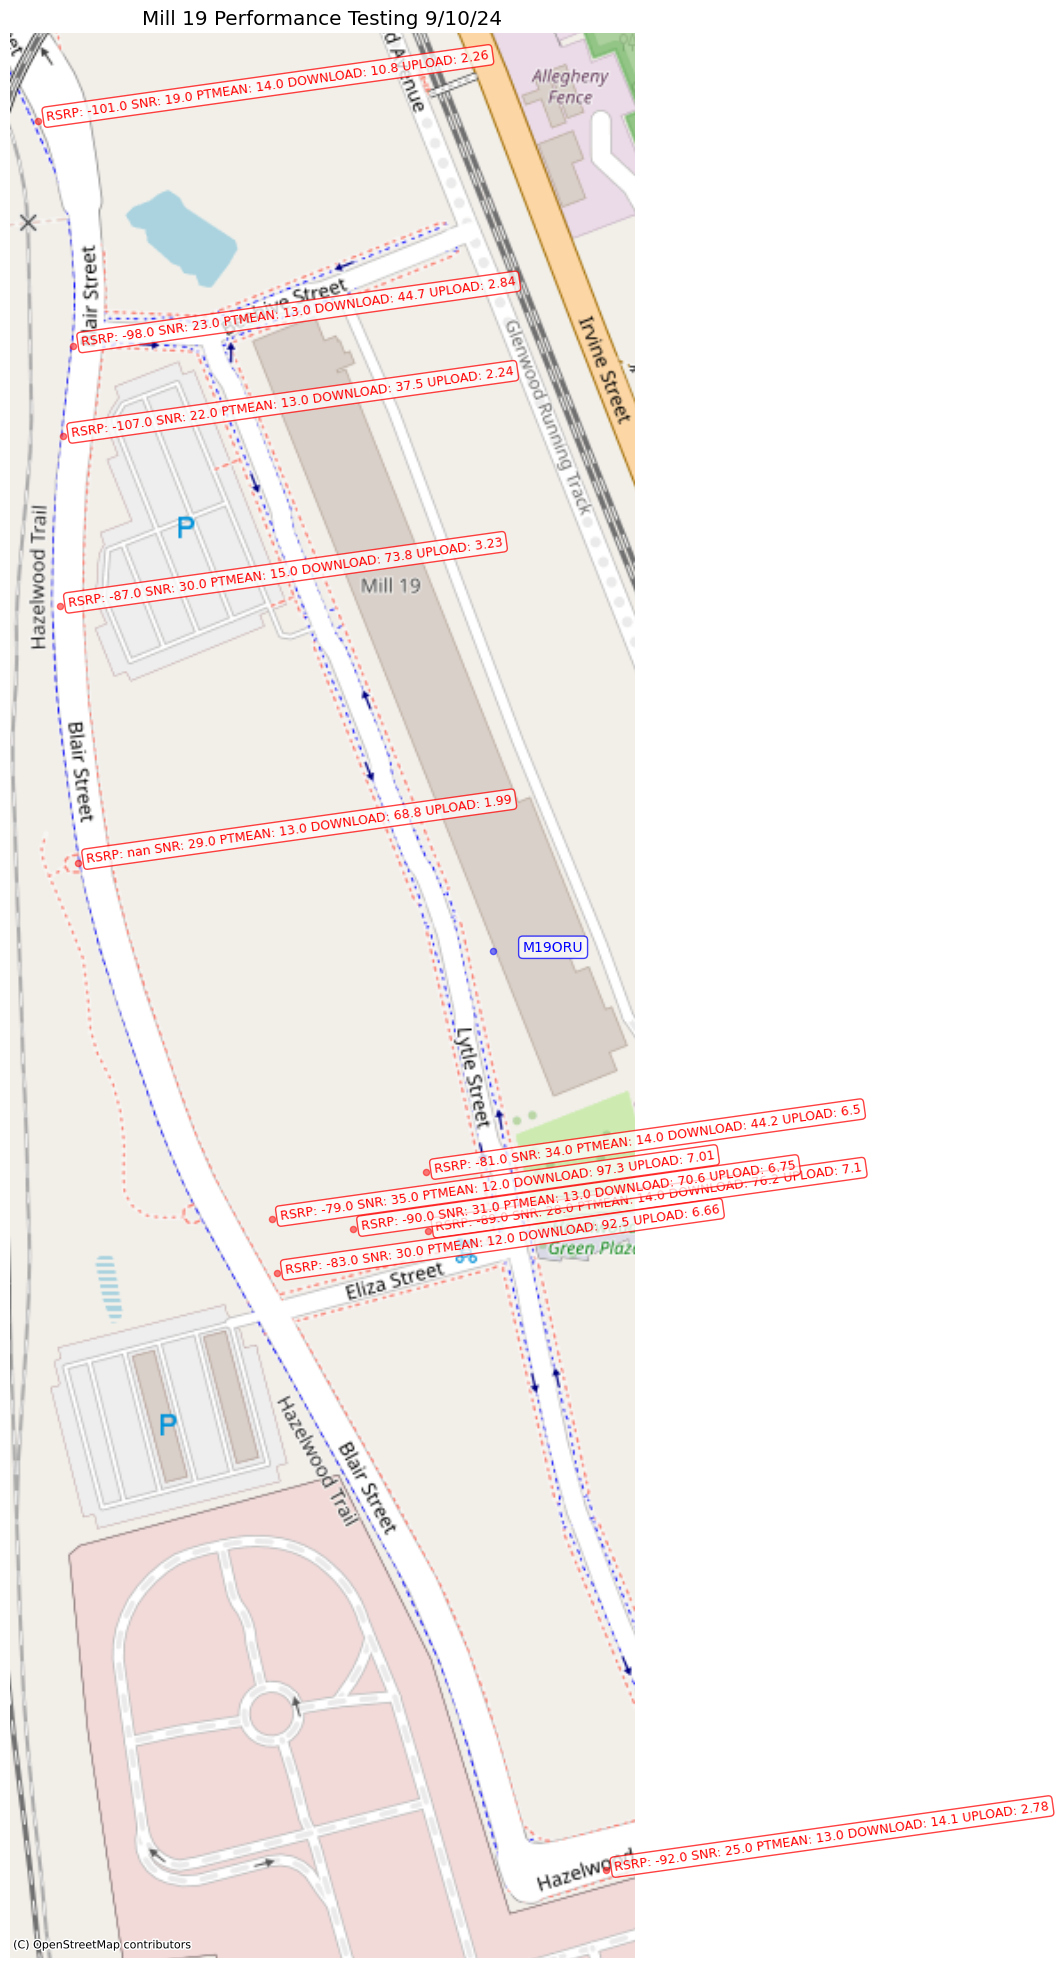

In [21]:
def gp_plotLabels(fgp2,labelcol="label",ax=None,mapon=True,xoffset=0,yoffset=0, figsize=(30,30), **kwargs):
    '''   GeoPandas DataFrame with 'geometry'containing Points '''
    if mapon: 
        fgp2 = fgp2.to_crs(epsg=3857)
    if ax is None: 
        ax = plt.figure().add_subplot(111)
    xlst,ylst = getPointXY(fgp2)
    # print(f"x={x}, y={y}")
    for x,y,label in zip(xlst,ylst,fgp2[labelcol]):
        ax.text(x+xoffset,y+yoffset,label,**kwargs)
    return ax

def plotMap(fgp,title="NONE",saveon=False,filename="tmp.png",ax=None):
    bbox=dict(facecolor='none', edgecolor='red', boxstyle='round')
    plt.rcParams.update({'font.size': 12})
    # ax = gp_plotPoints(mapgb, ax=ax, mapon=True, alpha=0)
    ax = gp_plotPoints(fgp,ax=ax, mapon=True, title=title, s=20, c='red',figsize=(25,25))
    ax = gp_plotPoints(lmgb,ax=ax, mapon=True,s=20, c='blue')
    bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round',alpha=0.75)
    ax = gp_plotLabels(lmgb,ax=ax, xoffset = 20,mapon=True,c='blue',fontsize=10,bbox=bbox)
    bbox['edgecolor'] = "red"
    ax = gp_plotLabels(fgp,ax=ax,xoffset=5,labelcol='LABEL',mapon=True,c='red',fontsize=9,rotation=8,bbox=bbox)



    if saveon:
        savePlot(ax,filename)
    return ax
try:
    del ax
except:
    pass

tgpx = tgp.copy()
tgpx['LABEL'] = tgpx.apply(lambda xx: f"RSRP: {xx.RSRP} SNR: {xx.SNR} PTMEAN: {xx.PTMEAN} DOWNLOAD: {xx.DOWNLOAD} UPLOAD: {xx.UPLOAD}",axis=1)

ax = plotMap(tgpx,title="Mill 19 Performance Testing 9/10/24", filename="Mill19-Performance-Testing-2024-09-10.png",saveon=False)
